In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import math 

In [3]:
filename = '20230323_bothcaps_marvin_slow'
df_rawdata = pd.read_csv('./data/' + filename + '.csv')
df_rawdata.head() # Check for correct data type
df_rawdata_proto = df_rawdata[df_rawdata["name"] == "Prototype"]
df_rawdata_capno = df_rawdata[df_rawdata["name"] == "Capnostat"]

df_rawdata.head()

,name,type,start_time,duration,data,error
0,Prototype,data,0.001262,0.000989,.,NaN
1,Prototype,data,0.002304,0.000989,º,NaN
2,Prototype,data,0.003345,0.000989,b,NaN
3,Prototype,data,0.004386,0.000989,.,NaN
4,Prototype,data,0.005428,0.000989,.,NaN


In [4]:
#Prep of the Capnostat Data
capno_rawdata = df_rawdata_capno['data']
capno_time = df_rawdata_capno['start_time']

# Convert series data into numpy arrays for ease of manipulation.
capno_cleandata = capno_rawdata.to_numpy(dtype=int)
capno_time = capno_time.to_numpy(dtype=float)


# Remove all negative mmHg values (and respective timestamps) for clinical relevance.
for i in range(0, len(capno_cleandata)):
    capno_cleandata[i] = capno_cleandata[i]/2
    if capno_cleandata[i] <= 0:
        capno_time[i] = -1

capno_cleandata = [value for value in capno_cleandata if value > 0]
capno_time = [value for value in capno_time if value != -1]

# Pass data through a medfilter to clean up periodic impulse signals.
#
capno_cleandata = signal.medfilt(capno_cleandata)


In [5]:
#Prep of Prototype Data:
result = ""
proto_rawdata = df_rawdata_proto['data']
proto_rawtimes = df_rawdata_proto['start_time']


for index, value in proto_rawdata.items():
    result += value
proto_t_array = proto_rawtimes.to_numpy(dtype=float)
#i was unsure whether result made sense so I printed the first 20 char's
#Print the first 20 characters to see if the result string makes sense:
print("First 20 chars of result: \n"+result[0:20]+"\n end of chars")
#Notice that it outputs a bunch of weird chracters, a new line character, and then some data

#Possible Solution 1:
#we could look for the first newline character, check the distance to the next one, and if its not long enough move onto the next one
#this works because we know our data must at some point go through a \n###,###\n so we can use this as our "base case" and anything outside is random stuff
#it also protects against the case we get two \n's in a row, because we can get random shit at the start of our data and that could could mean \n\n\n

#Possible Solution 3:
#we could just do nothing and hope this works perfectly. I have a feeling this could bite us in the ass later.

# Remove short data from the beginning of the result string.
# Step 1: Remove nonsense (i.e., non-numerical) data from the beginning
numericstart = result[0:result.find(',')].isnumeric()
print("Is the start numeric?: "+str(numericstart))

num_removed = 0 # Number of time values to be removed
while not numericstart:
    result = result.replace(result[0], '', 1)
    num_removed += 1
    print("Result first 20 chars after valid character check: "+result[0:20])
    if result[0:result.find(',')].isnumeric():
        numericstart = True

#Looks like your loop sucessfully removes everything until the first number, which is great!

# Remove respective time values
for i in range(0, num_removed, 1):
    proto_t_array[i] = -1
proto_t_array = [value for value in proto_t_array if value != -1]

# Step 2: Ensure numeric data is valid (i.e., not short) in the beginning
# If invalid, omits data up to and including the next \n and checks again.
properdata = len(result[0:result.find(',')]) == 3
print("Is the data beginning proper? "+str(properdata))
#What if you get this as your input: 1111, 123\n
#its totally possible to get random gibberish at the beginning of transmission so the 1111 is a possible input, so we gotta consider it

num_removed1 = 0 
while not properdata:
    removal = len(result[0:result.find('\n')+1])
    result = result.replace(result[0:result.find('\n')+1], '', 1)
    num_removed1 += removal
    print("Result first 20 chars after valid data check: "+result[0:20])
    if len(result[0:result.find(',')]) == 3: #
        properdata = True

# Remove respective time values
for i in range(0, num_removed1, 1):
    proto_t_array[i] = -1
proto_t_array = [value for value in proto_t_array if value != -1]

# Step 3: ... TODO: explain what this does!
properend = result.rfind('\n') == len(result)-1
print("Is the end of this data proper?:" + str(properend))
print("End of the data:" + result[-10:])
#If you look at the end of the data it seems we have an extra CO2 data point but not a nonco2, so we should cut up to that \n before the co2 numbers
num_removed = 0
while not properend:
    removal = len(result) - (result.rfind('\n')+1)
    remove_sub = result[-removal:]
    print("Looking for newline:"+str(result.rfind('\n')+1))
    print("Length to remove:"+str(removal))

    result = result[::-1].replace(remove_sub[::-1], ''[::-1], 1)[::-1]
    num_removed += removal

    if result.rfind('\n') == len(result)-1:
        properend = True
#Lets look at result at the end of the removal:
print("Removed result output:" + str(result[-10:]))


# Remove respective time values
for i in range(len(proto_t_array)-num_removed, len(proto_t_array), 1):
    proto_t_array[i] = -1
proto_t_array = [value for value in proto_t_array if value != -1]

First 20 chars of result: 
.ºb...130,132
128,1
 end of chars
Is the start numeric?: False
Result first 20 chars after valid character check: ºb...130,132
128,13
Result first 20 chars after valid character check: b...130,132
128,131
Result first 20 chars after valid character check: ...130,132
128,131
Result first 20 chars after valid character check: ..130,132
128,131

Result first 20 chars after valid character check: .130,132
128,131
1
Result first 20 chars after valid character check: 130,132
128,131
12
Is the data beginning proper? True
Is the end of this data proper?:False
End of the data:,230
228,
Looking for newline:98712
Length to remove:4
Removed result output:
226,230



In [6]:
# Make a numbers array with each item being (co2, nonco2)
numbers = result.split('\n')
# Deal with any \r that shows up in numbers array
for i in range(0, len(numbers)):
    numbers[i] = str(numbers[i])
    numbers[i] = numbers[i].replace('\r', '')
    # Pop any short data omitted in the previous cell
    if numbers[i] == '':
        numbers.pop(i)
print(numbers)
#Looks like you may have deleted a little too much before, fix the removing from end and I suspect the rest of this will look good

# Define a box signal of length n and height 1/n to use for box filtering
n = 25
filt = np.full(n,1/n)

co2 = []
nonco2 = []
co2_nonco2_diff = []
nonco2_co2_diff= []
ratio = []

co2_filt = []
nonco2_filt = []
co2_nonco2_filt_diff = []
nonco2_co2_filt_diff = []

for i in range(0, len(numbers), 1):
    string = numbers[i].split(',')
    co2.append( 5 * (float(string[0]) / 1024 ))
    nonco2.append( 5 * (float(string[1]) / 1024 ))

# Define prototype timeframe as an array of evenly spaced time values from the first
# recorded prototype timestamp to the last, based on the number of \n from the data
proto_time = np.linspace(proto_t_array[0], proto_t_array[len(proto_t_array)-1], len(co2))
proto_time_filt = []

# Apply the previously defined box filter
co2_filt = np.convolve(co2, filt, 'valid')
nonco2_filt = np.convolve(nonco2, filt, 'valid')

# Define filtered prototype time array based on n
for i in range(0, len(proto_time), 1):
    proto_time_filt.append(proto_time[i])
for i in range(len(proto_time_filt)-(n-1), len(proto_time_filt), 1):
    proto_time_filt[i] = -1
proto_time_filt = [value for value in proto_time_filt if value != -1]

# Calculate differences and ratio (both filtered and unfiltered)
for j in range(0, len(co2), 1):
    co2_nonco2_diff.append(float(co2[j] - nonco2[j]))
    nonco2_co2_diff.append(float(nonco2[j] - co2[j]))
    
for j in range(0, len(co2_filt), 1):
    co2_nonco2_filt_diff.append( float(co2_filt[j] - nonco2_filt[j]) )
    nonco2_co2_filt_diff.append(float(nonco2_filt[j] - co2_filt[j]))
    ratio.append( (float(nonco2_filt[j] - co2_filt[j])) / float(nonco2_filt[j]))


# Phase shift testing, TODO: finalize this code #note: this is DC offset, not phase shift.
#offset = co2[0] - nonco2[0]
#for i in range(0, len(co2), 1):
 #   co2[i] = co2[i] - offset



['130,132', '128,131', '129,131', '128,132', '129,130', '128,132', '129,130', '127,131', '129,131', '126,130', '129,133', '128,131', '130,131', '127,131', '129,131', '128,132', '130,132', '128,132', '130,131', '127,131', '130,131', '128,132', '130,132', '128,131', '130,131', '128,131', '129,131', '127,131', '130,133', '128,131', '130,131', '128,132', '130,132', '128,131', '130,132', '127,129', '129,131', '128,133', '130,132', '128,132', '130,131', '128,131', '130,132', '128,131', '130,132', '128,131', '129,131', '128,131', '129,131', '128,132', '130,131', '128,132', '130,132', '128,131', '129,131', '128,131', '130,131', '127,131', '130,132', '128,132', '130,131', '127,131', '129,131', '127,131', '129,131', '127,131', '129,131', '127,131', '130,132', '128,131', '129,130', '128,132', '129,131', '128,132', '130,131', '128,131', '130,132', '128,131', '129,131', '127,132', '130,131', '128,132', '131,133', '128,131', '130,131', '128,131', '130,131', '128,132', '130,131', '128,130', '129,130'

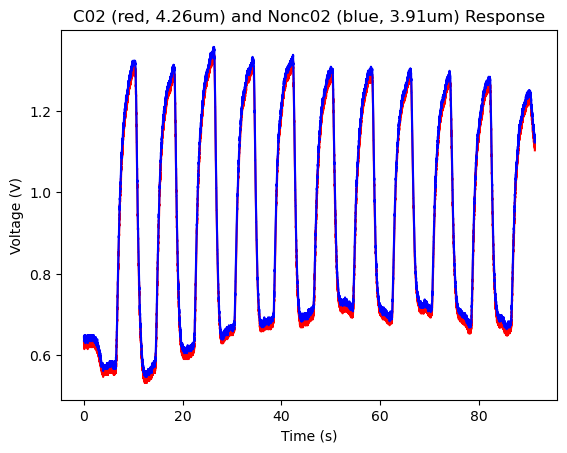

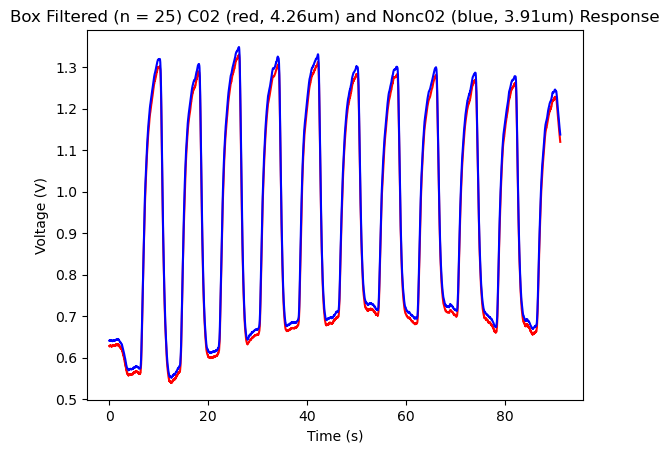

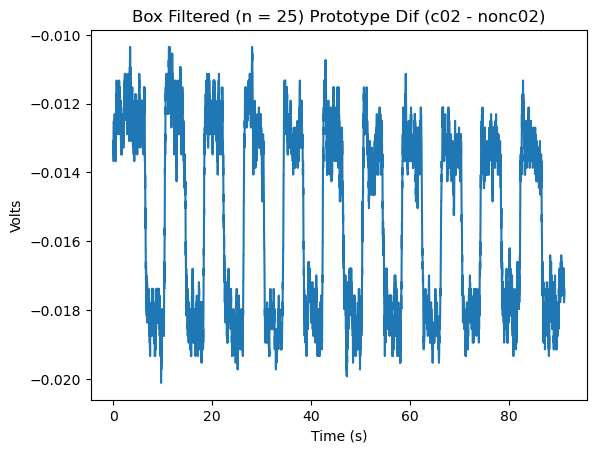

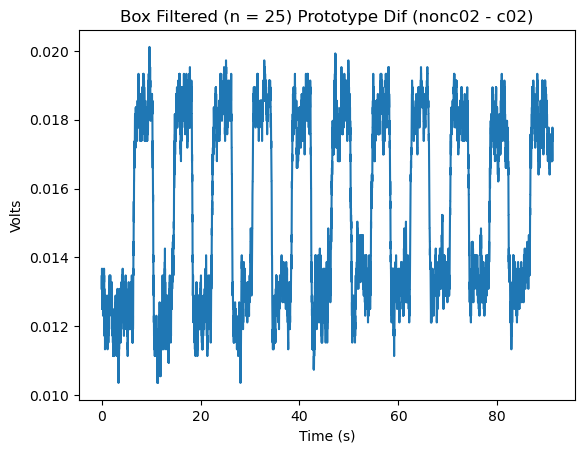

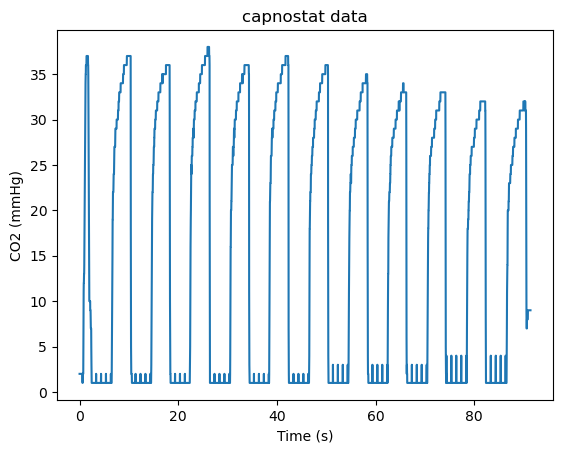

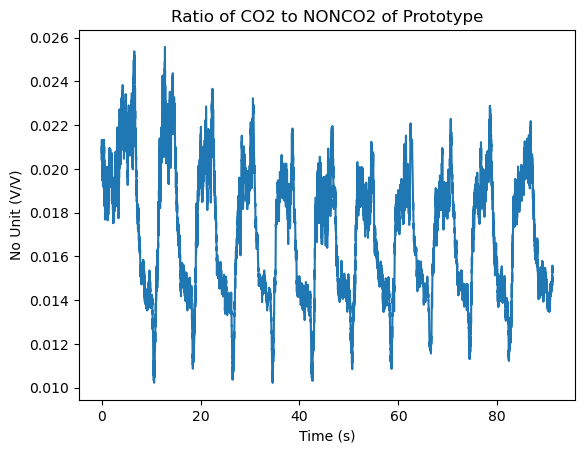

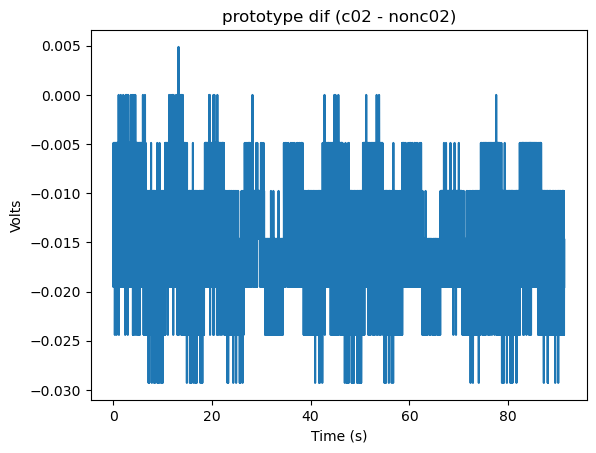

4564 10968


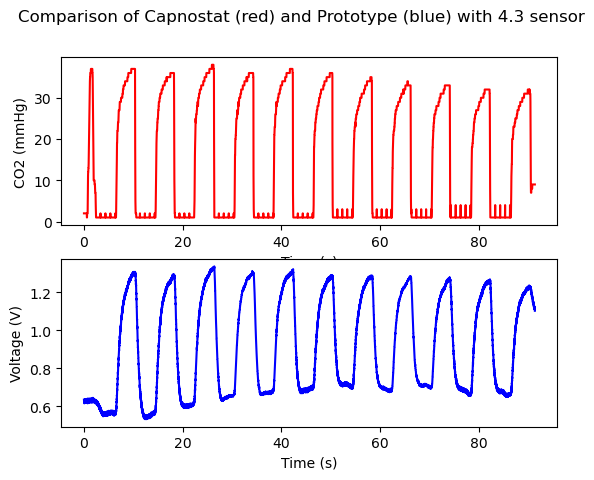

In [8]:
#Plotting Data after Filtering/Processing

plt.title("C02 (red, 4.26um) and Nonc02 (blue, 3.91um) Response")
plt.plot(proto_time, co2, color="red")
plt.plot(proto_time, nonco2, color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.show()

plt.title("Box Filtered (n = 25) C02 (red, 4.26um) and Nonc02 (blue, 3.91um) Response")
plt.plot(proto_time_filt, co2_filt, color="red")
plt.plot(proto_time_filt, nonco2_filt, color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.show()

plt.title("Box Filtered (n = 25) Prototype Dif (c02 - nonc02)")
plt.plot(proto_time_filt, co2_nonco2_filt_diff)
plt.xlabel("Time (s)")
plt.ylabel("Volts")
plt.show()

plt.title("Box Filtered (n = 25) Prototype Dif (nonc02 - c02)")
plt.plot(proto_time_filt, nonco2_co2_filt_diff)
plt.xlabel("Time (s)")
plt.ylabel("Volts")
plt.show()

plt.title("capnostat data")
plt.plot(capno_time, capno_cleandata)
plt.ylabel("CO2 (mmHg)")
plt.xlabel("Time (s)")
plt.show()

plt.title("Ratio of CO2 to NONCO2 of Prototype")
plt.plot(proto_time_filt, ratio)
plt.xlabel("Time (s)")
plt.ylabel("No Unit (V/V)")
plt.show()

plt.title("prototype dif (c02 - nonc02)")
plt.plot(proto_time, co2_nonco2_diff)
plt.xlabel("Time (s)")
plt.ylabel("Volts")
plt.show()
fig, axs = plt.subplots(2)
fig.suptitle("Comparison of Capnostat (red) and Prototype (blue) with 4.3 sensor")
axs[0].plot(capno_time, capno_cleandata, color="red")
axs[0].set(xlabel="Time (s)")
axs[0].set(ylabel="CO2 (mmHg)")
axs[1].plot(proto_time, co2, color="blue")
axs[1].set(xlabel="Time (s)")
axs[1].set(ylabel="Voltage (V)")

print(str(len(capno_cleandata)) + " " + str(len(co2_nonco2_diff)))

414
(array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),)
(array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98]),)
(array([ 43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78, 407, 408, 409,
       410, 411, 412, 413]),)
(array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),)
(array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52, 391, 392, 393, 394, 395, 396, 397, 398, 399,
       400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
       413]),)
(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21

/var/folders/dk/ntqqxtcj77d6kpjl7pz6dbbr0000gn/T/ipykernel_3262/3431599698.py:26: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  print(np.where(proto_segment == peak_proto))


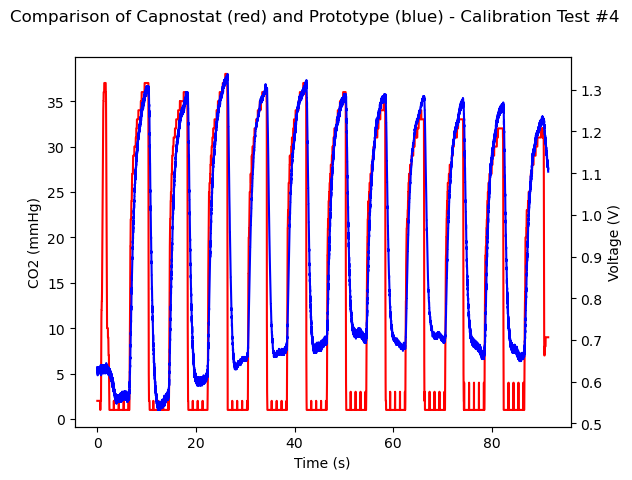

Text(0.5, 1.0, 'Calibration Curve - Test #4')

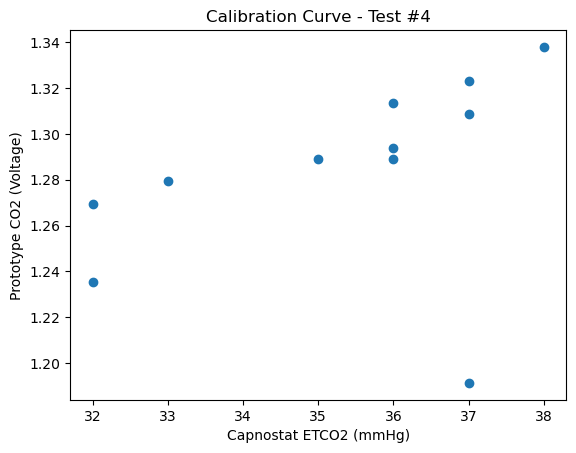

In [9]:
# need to floor index because indexes are integers and we dont want to go past the end of the array
breaths = 11
breath_length_capnostat = math.floor(len(capno_cleandata) / breaths)
print(breath_length_capnostat) 
#I got lucky... the length divided by 5 basically breaks up the signal into 5 equal breaths.
#def not always true but I'll take it!
capnostat_breaths = np.zeros(breaths)
capnostat_breaths_times = np.zeros(breaths)
#print(breath_length_capnostat)
for i in range(breaths):
    capno_segment = capno_cleandata[(i*breath_length_capnostat):((i+1)*breath_length_capnostat)]
    # peak_capno = max(capno_cleandata[(i*breath_length_capnostat):((i+1)*breath_length_capnostat)])
    peak_capno = max(capno_segment)
    print(np.where(capno_segment == peak_capno))
    capnostat_breaths[i] = peak_capno
#print(capnostat_breaths)
#the data looks pretty good ngl... 1st breath is highest, and goes down slowly from there.

#let's repeat with prototype
breath_length_proto = math.floor(len(co2) / breaths)
#print(breath_length_proto)
prototype_breaths = np.zeros(breaths)
for i in range(breaths):
    proto_segment = co2[(i*breath_length_proto):((i+1)*breath_length_proto)]
    peak_proto = max(proto_segment)
    print(np.where(proto_segment == peak_proto))
    prototype_breaths[i] = peak_proto
#print(prototype_breaths)

# Plot the graphs overlaid and the calibration curve. 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.suptitle("Comparison of Capnostat (red) and Prototype (blue) - Calibration Test #4")
ax1.plot(capno_time, capno_cleandata, color= "red")
ax1.set(xlabel="Time (s)")
ax1.set(ylabel= "CO2 (mmHg)")
ax2.plot(proto_time, co2, color= "blue")
ax2.set(ylabel = "Voltage (V)")
plt.show()

plt.scatter(capnostat_breaths, prototype_breaths)
plt.xlabel("Capnostat ETCO2 (mmHg)")
plt.ylabel("Prototype CO2 (Voltage)")
plt.title("Calibration Curve - Test #4")


MORE METRICS DOWN BELOW!

<function matplotlib.pyplot.show(close=None, block=None)>

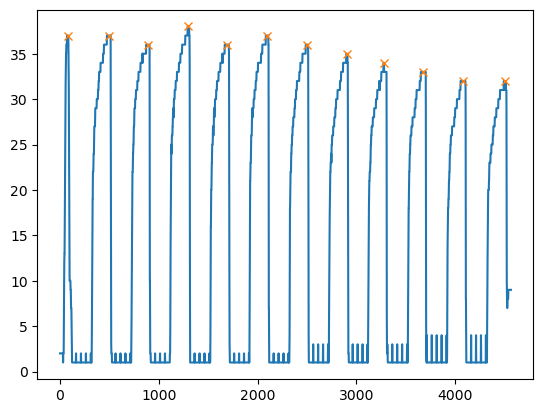

In [10]:
# Testing scipy peak detection
capno_peaks, _ = signal.find_peaks(capno_cleandata, height = 30, distance = 60)
# capno_peaktimes = capno_time[capno_peaks]
plt.plot(capno_cleandata)
plt.plot(capno_peaks, capno_cleandata[capno_peaks], "x")
plt.show

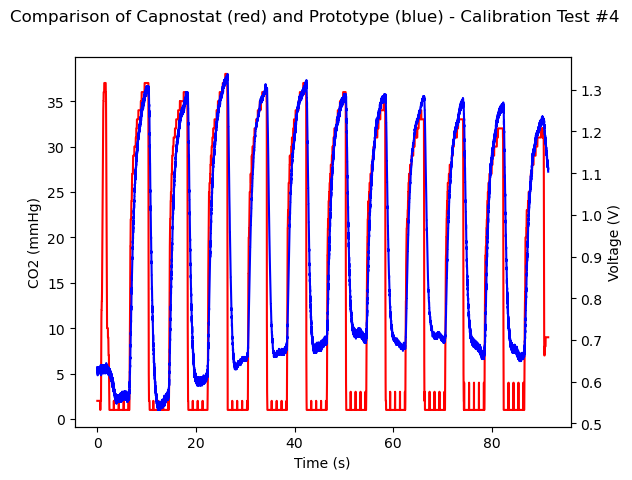

[ 1230  2192  3168  4093  5087  6025  6985  7928  8892  9874 10838]
[1523, 2493, 3449, 4718, 5367, 6327, 7278, 8270, 9217, 10189]
[1289, 2277, 3225, 4252, 5126, 6036, 7050, 8063, 9001, 9883]
[1523, 2493, 3449, 4718, 5367, 6327, 7278, 8270, 9217, 10189]


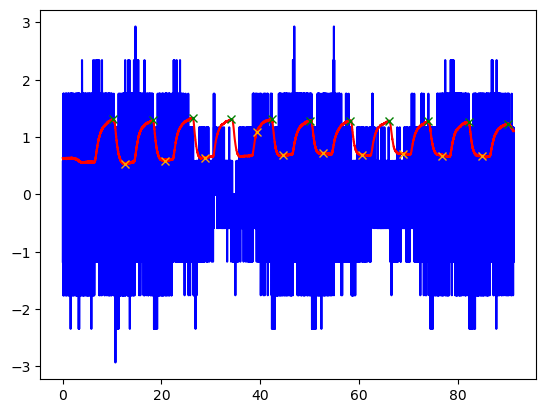

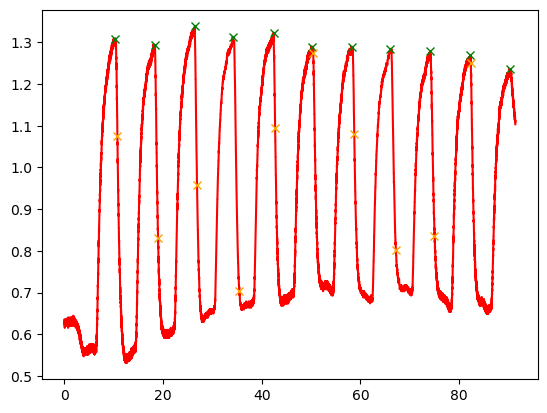

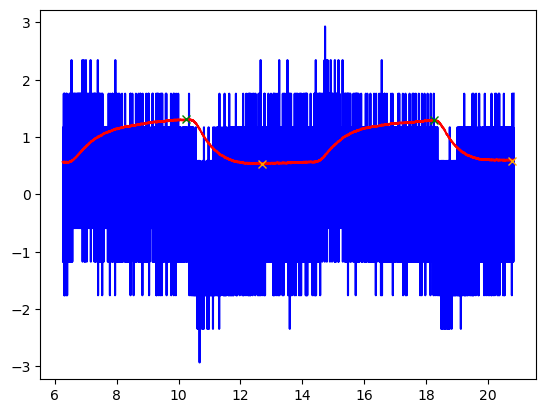

In [11]:
# More Metrics!

# TODO: PEtCO2 Time stamp (Marvin)
# I'll collect these in the previous cell then bring them down here.
# TODO: Rise time (Marvin)

# TODO: Start of the wave (Marvin)

# TODO: End of the wave (Keerthana)
# Plot the graphs overlaid and the calibration curve. 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.suptitle("Comparison of Capnostat (red) and Prototype (blue) - Calibration Test #4")
ax1.plot(capno_time, capno_cleandata, color= "red")
ax1.set(xlabel="Time (s)")
ax1.set(ylabel= "CO2 (mmHg)")
ax2.plot(proto_time, co2, color= "blue")
ax2.set(ylabel = "Voltage (V)")
plt.show()

# find peaks and the derivative of the prototype signal
from numpy import diff
from scipy.signal import find_peaks
dydx = diff(co2)/diff(proto_time)
d2ydx2 = diff(dydx)/diff(proto_time[1:])
peaks, _ = find_peaks(co2, height=1.2, distance=400)
print(peaks)

fig, ax = plt.subplots()
ax.plot(proto_time[1:], dydx, color="blue", label="derivative")
ax.plot(proto_time, co2, color="red", label="original")
co2 = np.array(co2)
proto_time = np.array(proto_time)
ax.plot(proto_time[peaks], co2[peaks], "x", color="green")

end_times = []
for i in range(len(peaks) - 1):
    # index = np.argmin(dydx[peaks[i]:peaks[i+1]]) + peaks[i]
    # end_times.append(index)
    min_index = np.argmin(dydx[peaks[i]:peaks[i+1]])
    max_index = np.argmax(dydx[peaks[i]:peaks[i+1]])
    approx_index = int((min_index + max_index)/2)
    end_times.append(approx_index + peaks[i])
print(end_times)
ax.plot(proto_time[end_times], co2[end_times], "x", color="orange")

fig, ax = plt.subplots()
ax.plot(proto_time, co2, color="red", label="original")
co2 = np.array(co2)
proto_time = np.array(proto_time)
ax.plot(proto_time[peaks], co2[peaks], "x", color="green")

end_times = []
for i in range(len(peaks) - 1):
    start_i = peaks[i] + 300
    end_i = int((peaks[i] + peaks[i+1])/2)
    index = np.argmin(d2ydx2[start_i:end_i]) + peaks[i]
    end_times.append(index)
print(end_times)
ax.plot(proto_time[end_times], co2[end_times], "x", color="orange")

fig, ax = plt.subplots()
ax.plot(proto_time[1:][750:2500], dydx[750:2500], color="blue", label="derivative")
ax.plot(proto_time[750:2500], co2[750:2500], color="red", label="original")
co2 = np.array(co2)
proto_time = np.array(proto_time)
ax.plot(proto_time[peaks[:2]], co2[peaks[:2]], "x", color="green")

end_times = []
for i in range(len(peaks) - 1):
    min_index = np.argmin(dydx[peaks[i]:peaks[i+1]])
    max_index = np.argmax(dydx[peaks[i]:peaks[i+1]])
    approx_index = int((min_index + max_index)/2)
    end_times.append(approx_index + peaks[i])
print(end_times)
ax.plot(proto_time[end_times[:2]], co2[end_times[:2]], "x", color="orange")

# TODO: Palteau slope (Keerthana) 

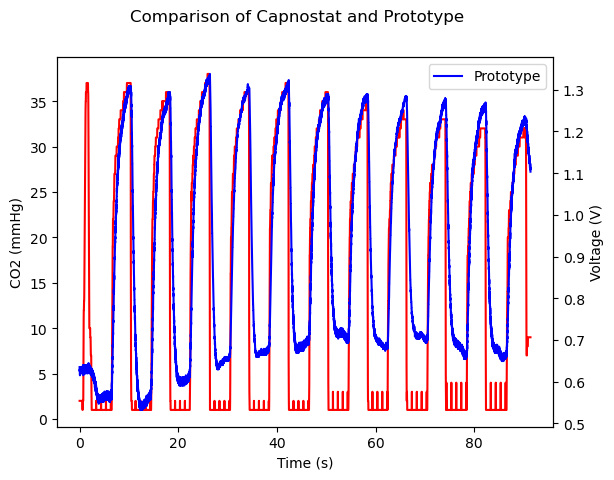

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.suptitle("Comparison of Capnostat and Prototype")
ax1.plot(capno_time, capno_cleandata, color= "red", label="Capnostat")
ax1.set(xlabel="Time (s)")
ax1.set(ylabel= "CO2 (mmHg)")
ax2.plot(proto_time, co2, color= "blue", label="Prototype")
ax2.set(ylabel = "Voltage (V)")
plt.legend()
plt.show()

#t1 = capno_time
#line1 = capno_cleandata
#t2 = proto_time
#line2 = co2

In [13]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig = plt.figure()
axis = plt.axes(xlim = (0, 100), ylim = (0.5, 1.4))
line, = axis.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line, 

xdata, ydata = [], []

def animate(i):
    xdata = proto_time[:i]
    ydata = co2[:i]
    line.set_data(xdata, ydata)

    return line,

anim = FuncAnimation(fig, animate, init_func = init, 
                               frames = 1000, interval = 20, blit=True)
plt.show


<IPython.core.display.Javascript object>

<function matplotlib.pyplot.show(*, block=None)>

In [14]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
line2 = ax.plot(proto_time[0], co2[0], label="prototype")[0]
ax.set(xlim=[0, 100], ylim=[0.5, 1.4], xlabel='Time [s]', ylabel='Z [m]')

def update(frame):
    x = proto_time[:frame]
    y = co2[:frame]

    line2.set_xdata(proto_time[:frame])
    line2.set_ydata(co2[:frame])
    return [line2]

ani = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=1)
plt.show()

FFwriter=animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
ani.save('plswork.mp4', writer=FFwriter)

# ani.save('test.mp4', 
#           writer = 'PillowWriter', fps = 30)

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

# NOTE: Do not run the below cell until ALL NECESSARY METRICS HAVE BEEN COLLECTED!

In [ ]:
# Save all of the data to a CSV file, including calibration data.
# Make an array of nulls to append to both calibration arrays to allow for csv creation.
# Arrays must be the same length as the dataframe to add to it.

empty = []
for i in range(len(capnostat_breaths), len(df_rawdata)):
    empty.append(None)
capnostat_breaths = np.append(capnostat_breaths, empty)
prototype_breaths = np.append(prototype_breaths, empty)

df_rawdata['Capnostat Calibration Points (mmHg)'] = capnostat_breaths
df_rawdata['Prototype Calibration Points (V)'] = prototype_breaths
df_rawdata.to_csv(filename+'_append_calibration.csv')
